In [1]:
%%bash
nrnivmodl

/home/alex/Dropbox/Williams-etal-Synaptic-Transport/code/05
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/alex/neuron/nrn-7.4/include/nrn" -I"/home/alex/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/alex/neuron/nrn-7.4/include/nrn -I/home/alex/neuron/nrn-7.4/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/home/alex/neuron/nrn-7.4/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/home/alex/neuron/nrn-7.4/x86_64/lib"  h.lo kadist.lo kaprox.lo kdrca1.lo km.lo na3n.lo naxn.lo vecevent.lo mod_func.lo  -L"/home/alex/neuron/nrn-7.4/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/home/alex/neuron/nrn-7.4/x86_64/lib" "/hom

In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.synapses import add_exp2
import time
%matplotlib inline
np.random.seed(123456789)


# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

# Function to get a random segment within a region of the dendrite
def randseg(region=None):
    tmp = np.random.uniform(0,1)
    if region is None:
        region = np.random.choice(['apic','dend_5','dend'])
    if region == 'apic':
        comp = h.apic[int(np.random.uniform(22,30))]
    elif region == 'dend_5':
        comp = h.dend_5[int(np.random.uniform(22,28))]
    elif region == 'dend':
        comp = h.dend[int(np.random.uniform(60,70))]
    return comp(tmp)

# Add a bunch of synapses
n_syn = 120
syn_rate = 50.0  # Hz
syndata = []
for i in range(n_syn): 
    spktimes = np.random.uniform(1,h.tstop-1,int(syn_rate*h.tstop/1e3))
    syndata.append(add_exp2(h,randseg(),spktimes,e=0,tau1=0.5,tau2=20,weight=0.001))

In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

In [4]:
# plt.figure()
leaf_dists = {}
for sec in sec_list:
    sref = h.SectionRef(sec=sec)
    if len(sref.child) == 0:
        leaf_dists[dist_to_soma(sec(0.5))] = sec

# plt.plot(leaf_dists.keys())
# plt.show()

In [5]:
max_dist = max(leaf_dists.keys())

# find primary neurite sections
primary = []
sref = h.SectionRef(sec=leaf_dists[max_dist])
while sref.has_parent():
    primary.append(sref.sec)
    sref = h.SectionRef(sec=sref.parent)

# find segments in primary neurite
primary_sec = np.zeros(len(sec_list),dtype=bool)
for (i,sec1) in enumerate(sec_list):
    for sec2 in primary:
        if sec1 == sec2 and i < 61:
            primary_sec[i] = 1

primary_segs = []
for (i,sec) in enumerate(sec_list):
    for seg in range(sec.nseg):
        primary_segs.append(primary_sec[i])

In [6]:
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm

# fig = plt.figure(figsize=(8,8))
# shapeax = plt.subplot(111, projection='3d')
# lines = shapeplot(h,shapeax,cvals=primary_segs,\
#                   cmap=plt.cm.cool,order='pre',lw=2)
# shapeax.view_init(elev=80,azim=-90)
# plt.axis('off')
# plt.title('primary neurite',fontweight='bold',fontsize=14)

In [7]:
(v,v_labels) = ez_record(h,order='pre')
h.finitialize() # has to come after ez_record

start_time = time.time()
while h.t < h.tstop:
    h.fadvance()
elapsed_time = time.time() - start_time

v = ez_convert(v)
t = np.linspace(0,h.t,v.shape[0])
v_avg = np.mean(v,axis=0)

In [8]:
def sushi_system(a,b,c,d):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for the degradation of u* is given by the vector "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -d[i]
    
    return A

In [9]:
n = len(v_avg)

def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,timescale=1e-3):
    # F is a mixing factor between 0 and 1
    # --> F=0 produces uniform transport strategy
    # --> F=1 produces bottleneck strategy
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = list((1/(1+x)))
    b = list((1/(1+x**-1)))
    d = list(np.zeros(n))#list(np.ones(n)*1e-7)
    c = list(timescale*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c,d)
    return A

In [10]:
# Target spatial distribution:
utarg = (v_avg-np.min(v_avg))/(np.max(v_avg)-np.min(v_avg))*0.9 + 0.1
print len(utarg)

# matrix exponential used to solve linear system
from scipy.linalg import expm

# sparse matrix exponential
import scipy.sparse.linalg as sparse

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n)
u0[0] = 1.0  # compartment 0 is the soma

742


In [11]:
def snap_ss(u_ss,name,clim=[0,max(utarg)]):
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u_ss[n:],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    sm._A = []
    plt.colorbar(sm, shrink=0.5)
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

First Transport Pattern: Distal transport alone
-----

In [12]:
# Distal inputs alone
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 1e-3 # no proximal trafficking
utarg /= np.sum(utarg)

# Solve steady-state for both trafficking strategies
timescale_ax = np.logspace(-5,-3,10)
err = [[],[]]
tau = [[],[]]
for F in [0,1]:
    for ts in timescale_ax:
        print '*',
        A = get_sys_matrix(utarg,F=F,timescale=ts)
        u_ss = np.dot(expm(1e6*A),u0)
        w,v = np.linalg.eig(A[:n,:n])
        tau[F].append((-np.max(w))**-1)
        err[F].append(np.sum(np.abs(u_ss[n:]-utarg))) # L1 error

* * * * * * * * * * * * * * * * * * * *


/home/alex/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


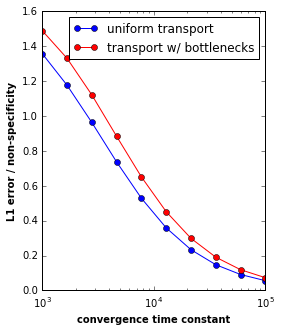

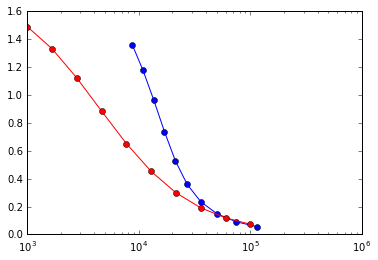

In [13]:
plt.figure(figsize=(4,5))
plt.plot(timescale_ax**-1,err[0],'o-b')
plt.plot(timescale_ax**-1,err[1],'o-r')
plt.xlabel('convergence time constant',fontweight='bold')
plt.ylabel('L1 error / non-specificity',fontweight='bold')
plt.xscale('log')
plt.legend(['uniform transport','transport w/ bottlenecks'])
#plt.savefig('tradeoff_distal.svg')

plt.figure()
plt.plot(tau[0],err[0],'o-b')
plt.plot(tau[1],err[1],'o-r')
plt.xscale('log')
plt.show()

In [14]:
# Distal and Proximal together
utarg = np.ones(len(seg_list))
utarg[:393] *= 10
utarg[393:] *= 1e-3 # no trafficking to basal dend
utarg /= np.sum(utarg)

# Solve steady-state for both trafficking strategies
err = [[],[]]
tau = [[],[]]
for F in [0,1]:
    for ts in timescale_ax:
        print '*',
        A = get_sys_matrix(utarg,F=F,timescale=ts)
        u_ss = np.dot(expm(1e6*A),u0)
        w,v = np.linalg.eig(A[:n,:n])
        tau[F].append((-np.max(w))**-1)
        err[F].append(np.sum(np.abs(u_ss[n:]-utarg))) # L1 error

* * * * * * * * * * * * * * * * * * * *


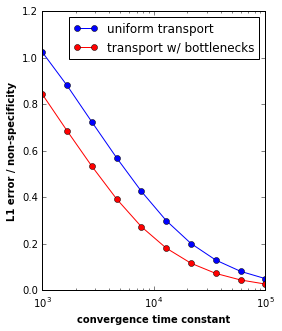

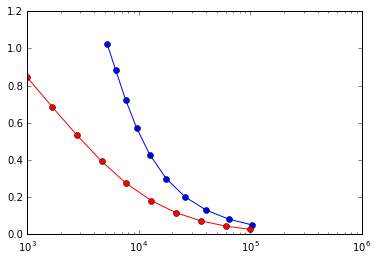

In [15]:
plt.figure(figsize=(4,5))
plt.plot(timescale_ax**-1,err[0],'o-b')
plt.plot(timescale_ax**-1,err[1],'o-r')
plt.xlabel('convergence time constant',fontweight='bold')
plt.ylabel('L1 error / non-specificity',fontweight='bold')
plt.xscale('log')
plt.legend(['uniform transport','transport w/ bottlenecks'])
#plt.savefig('tradeoff_proxdist.svg')

plt.figure()
plt.plot(tau[0],err[0],'o-b')
plt.plot(tau[1],err[1],'o-r')
plt.xscale('log')
plt.show()